Image Deconvolution with TV Regularization (Proximal ADMM Solver)
=================================================================

This example demonstrates the solution of an image deconvolution problem
with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - C \mathbf{x}
  \|_2^2 + \lambda \| D \mathbf{x} \|_{2,1} \;,$$

where $C$ is a convolution operator, $\mathbf{y}$ is the blurred image,
$D$ is a 2D finite fifference operator, and $\mathbf{x}$ is the
deconvolved image.

In this example the problem is solved via proximal ADMM, while standard
ADMM is used in a [companion example](deconv_tv_admm.rst).

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico
!pip install xdesign

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.optimize import ProximalADMM
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
N = 256  # image size
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)

Set up the forward operator and create a test signal consisting of a
blurred signal with additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
C = linop.Convolve(h=psf, input_shape=x_gt.shape)

Cx = C(x_gt)  # blurred image
noise, key = scico.random.randn(Cx.shape, seed=0)
y = Cx + σ * noise

Set up the problem to be solved. We want to minimize the functional

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - C \mathbf{x}
  \|_2^2 + \lambda \| D \mathbf{x} \|_{2,1} \;,$$

where $C$ is the convolution operator and $D$ is a finite difference
operator. This problem can be expressed as

  $$\mathrm{argmin}_{\mathbf{x}, \mathbf{z}} \; (1/2) \| \mathbf{y} -
  \mathbf{z}_0 \|_2^2 + \lambda \| \mathbf{z}_1 \|_{2,1} \;\;
  \text{such that} \;\; \mathbf{z}_0 = C \mathbf{x} \;\; \text{and} \;\;
  \mathbf{z}_1 = D \mathbf{x} \;,$$

which can be written in the form of a standard ADMM problem

  $$\mathrm{argmin}_{\mathbf{x}, \mathbf{z}} \; f(\mathbf{x}) + g(\mathbf{z})
  \;\; \text{such that} \;\; A \mathbf{x} + B \mathbf{z} = \mathbf{c}$$

with

  $$f = 0 \quad g = g_0 + g_1$$
  $$g_0(\mathbf{z}_0) = (1/2) \| \mathbf{y} - \mathbf{z}_0 \|_2^2 \quad
  g_1(\mathbf{z}_1) = \lambda \| \mathbf{z}_1 \|_{2,1}$$
  $$A = \left( \begin{array}{c} C \\ D \end{array} \right) \quad
  B = \left( \begin{array}{cc} -I & 0 \\ 0 & -I \end{array} \right) \quad
  \mathbf{c} = \left( \begin{array}{c} 0 \\ 0 \end{array} \right) \;.$$

This is a more complex splitting than that used in the
[companion example](deconv_tv_admm.rst), but it allows the use of a
proximal ADMM solver in a way that avoids the need for the conjugate
gradient sub-iterations used by the ADMM solver in the
[companion example](deconv_tv_admm.rst).

In [4]:
f = functional.ZeroFunctional()
g0 = loss.SquaredL2Loss(y=y)
λ = 2.0e-2  # ℓ2,1 norm regularization parameter
g1 = λ * functional.L21Norm()
g = functional.SeparableFunctional((g0, g1))

D = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
A = linop.VerticalStack((C, D))

Set up a proximal ADMM solver object.

In [5]:
ρ = 5.0e-2  # ADMM penalty parameter
maxiter = 50  # number of ADMM iterations
mu, nu = ProximalADMM.estimate_parameters(A)

solver = ProximalADMM(
    f=f,
    g=g,
    A=A,
    B=None,
    rho=ρ,
    mu=mu,
    nu=nu,
    x0=C.adj(y),
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
)

Run the solver.

In [6]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  2.64e+00  1.161e+00  3.895e+01  1.308e+02
  10  3.66e+00  1.783e+02  1.551e+01  3.483e+00


  20  3.79e+00  2.142e+02  8.851e+00  2.516e+00
  30  3.91e+00  2.491e+02  5.314e+00  1.199e+00


  40  4.04e+00  2.782e+02  3.313e+00  7.924e-01


  49  4.15e+00  2.932e+02  2.155e+00  5.054e-01


Show the recovered image.

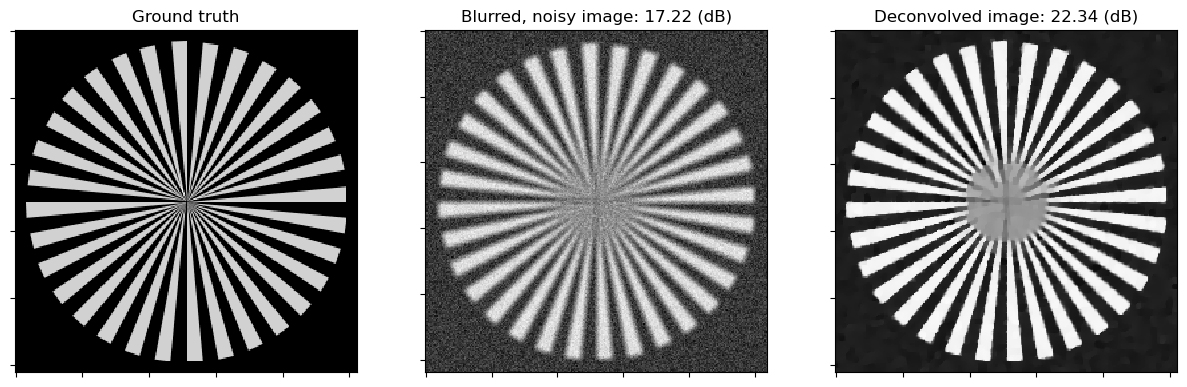

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
nc = n // 2
yc = y[nc:-nc, nc:-nc]
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, yc), fig=fig, ax=ax[1])
plot.imview(
    solver.x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, solver.x), fig=fig, ax=ax[2]
)
fig.show()

Plot convergence statistics.

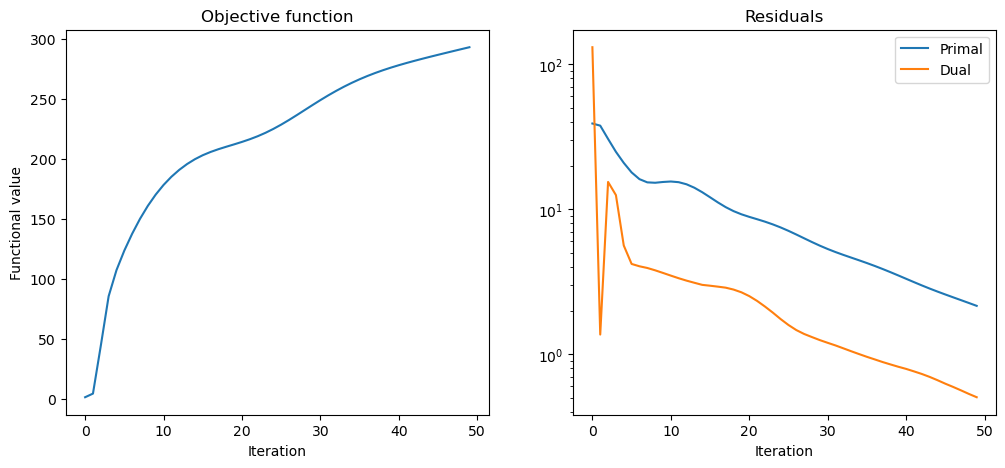

In [8]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()